<h2><center><font color='Green'>Kriging 

<h3><center><font color='Green'> Submitted by: Arefin Siddikui(L20554425)

<h4> Works Flow
<h6>1. Import Necessary Libraries
<h6>2. Set Working Directory
<h6>3. Creating Point Geodataframe from Field Data
<h6>4. Plotting the Collected Field Data 
<h6>5. Plotting the Field Data on the Pre-georeferenced field Image 
<h6>6. Determine Bounds for Grid Creation to Enable Interpolation (or Extrapolation)
<h6>7. Perform Ordinary Kriging to Determine the Optimal Variogram Model Using Actual Data
<h6>8. Create a bar plot of errors, highlighting the variogram model with the minimum root mean square error (RMSE).
<h6>9.  Perform Ordinary Kriging with the best fit Spherical Model on a grid
<h6>10. Plot the Predicted Surface on a grid and the Prediction Standard Error.


In [384]:
# Import Necessary libraries
import os
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib_map_utils as mapu 
from matplotlib_scalebar.scalebar import ScaleBar 
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from mpl_toolkits.mplot3d import Axes3D


In [385]:
# Set the working directory
path = r"C:/Users/asidd/Downloads/Final Project/Kriging"
image_path = r"C:/Users/asidd/Downloads/Final Project/Kriging/field_image_modified.tif"
os.chdir(path)


# Read the CSV file Field Data and create a GeoDataFrame
fd = pd.read_csv(fname)
lamaras = gpd.GeoDataFrame(a, geometry=gpd.points_from_xy(fd.X, fd.Y))
lamaras.crs = "EPSG:26915"


In [386]:
# Import Field Data from CSV File 
fname1 = 'Field_Data.csv'
fd = pd.read_csv(fname1)

In [387]:
# Create a point object a geometry column from the longitude and latitude columns
lamaras = gpd.GeoDataFrame(fd, geometry=gpd.points_from_xy(fd.X, fd.Y))

# Set the coordinate reference system (CRS) if you know it
lamaras.crs = 'EPSG:26915'  # UTM ZONE 15N Coordinate Systems (Projected Coordinate)

lamaras.head()


,Img_Label,X,Y,Z,Hor_Accuracy,Ver_Accuracy,Remarks,geometry
0,A,396103.8633,3323564.158,4.425630,0.10,0.10,Concrete Top Left,POINT (396103.863 3323564.158)
1,B,396136.7596,3323564.703,4.492191,0.10,0.10,Concrete Top Right,POINT (396136.76 3323564.703)
2,C,396136.4109,3323541.640,5.300878,0.23,0.22,Concrete Bottom Right,POINT (396136.411 3323541.64)
3,D,396103.5592,3323540.882,4.571488,0.13,0.15,Concrete Bottom Left,POINT (396103.559 3323540.882)
4,F1,396123.5924,3323552.059,4.698696,0.10,0.10,Field Point 1,POINT (396123.592 3323552.059)


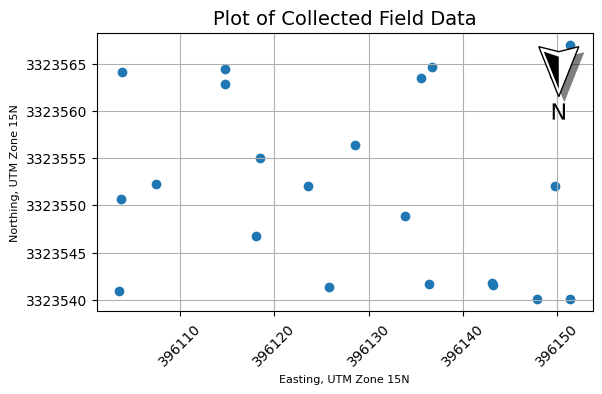

In [388]:
fig, ax = plt.subplots()
jeffas.plot(ax=ax)
plt.grid()

# Adding title and axis labels
ax.set_title("Plot of Collected Field Data", fontsize=14)
ax.set_ylabel("Northing, UTM Zone 15N", fontsize=8)
ax.set_xlabel("Easting, UTM Zone 15N", fontsize=8)

# Setting full digits for latitudes and longitudes
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))  # Full digits for longitude
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))  # Full digits for latitude

# Rotating longitude values by 45 degrees
plt.xticks(rotation=45)

# Adding the north arrow with 180 degrees rotation
mapu.north_arrow.north_arrow(ax=ax, location="upper right", rotation={"degrees": 180})

plt.show()



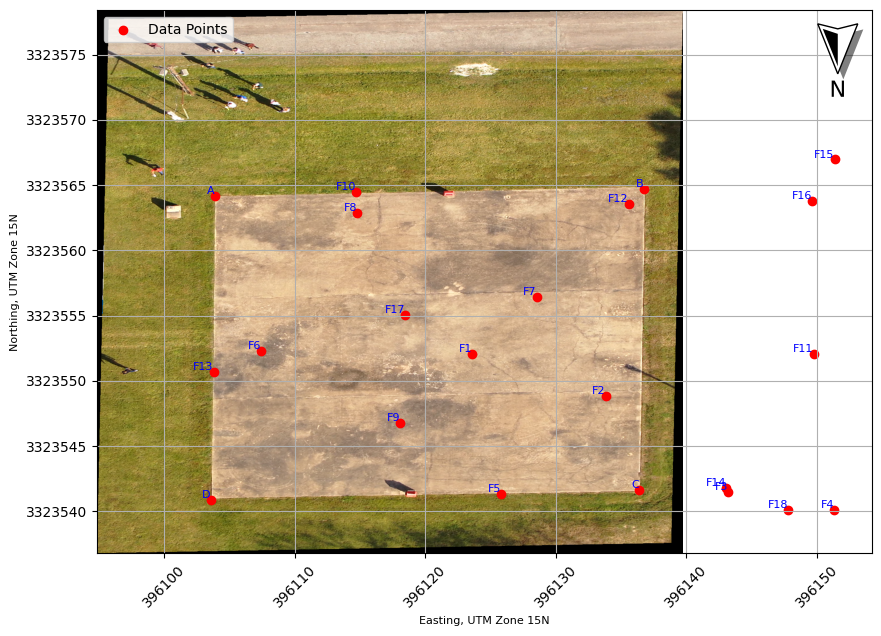

In [389]:
# Plot the georeferenced image with the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Open the georeferenced image
with rasterio.open(image_path) as src:
    show(src, ax=ax)  # Plot the image as a base layer

# Plot GeoDataFrame on top of the image
jeffas.plot(ax=ax, color='red', marker='o', label="Data Points")

# Add point labels
for x, y, label in zip(jeffas.geometry.x, jeffas.geometry.y, jeffas['Img_Label']):
    ax.text(x, y, label, fontsize=8, color='blue', ha='right', va='bottom')
    
# Setting full digits for latitudes and longitudes
ax.set_ylabel("Northing, UTM Zone 15N", fontsize=8)
ax.set_xlabel("Easting, UTM Zone 15N", fontsize=8)
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))  # Full digits for longitude
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))  # Full digits for latitude

# Rotating longitude values by 45 degrees
plt.xticks(rotation=45)

# Add grid, north arrow, and legend
plt.grid()
mapu.north_arrow.north_arrow(ax=ax, location="upper right", rotation={"degrees": 180})
ax.legend(loc="upper left")

plt.show()


In [390]:
# Obtain lat, Lon and z values for Z from lamaras UTM Zone 15N
x = list(lamaras.geometry.x)
y = list(lamaras.geometry.y)
z = list(lamaras.Z)

In [391]:
# Get the bounds of datasets to create a grid of size delta
delta = 2 # create 2 m x 2 m grid
xmin, ymin, xmax, ymax = lamaras.total_bounds
print(xmin, ymin, xmax,ymax)
gridx = np.arange(xmin,(xmax+delta),delta)
gridy = np.arange(ymin,(ymax+delta),delta)

396103.5592 3323540.109 396151.3764 3323566.964


In [393]:
# Perform ordinary Kriging and select the best variogram. 

models = ['linear', 'power', 'gaussian', 'exponential', 'spherical']
varioerr = []
for m in models:
    ok = OrdinaryKriging(x, y, z, variogram_model=m, verbose=False, enable_plotting=False)
    Aspred,ss = ok.execute("grid", x, y)
    err = np.nansum((z-Aspred)**2)
    rmse = np.sqrt(err/len(z))
    varioerr.append(rmse)

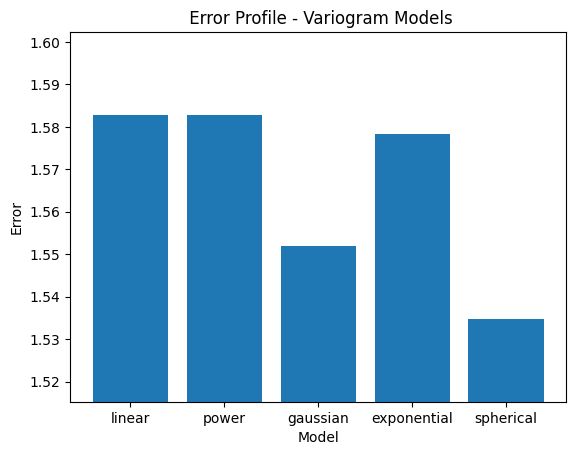

In [394]:
# Make a bar plot of errors and he best variogram gives minimum root mean sq. error
minlim = np.min(varioerr) - np.std(varioerr)
maxlim = np.max(varioerr) + np.std(varioerr)
plt.bar(models,varioerr)
plt.ylim(minlim,maxlim)
plt.ylabel('Error')
plt.xlabel('Model')
plt.title(' Error Profile - Variogram Models')
plt.show()

Among the models evaluated—'Linear', 'Power', 'Gaussian', 'Exponential', and 'Spherical'—the Spherical model emerges as the best fit. However, several other models also exhibit similar performance, as reflected in the closely spaced values on the Y-axis.

In [396]:
# Perform ordinary kriging with Spherical Model (best fit model)
ok = OrdinaryKriging(
    x, y, z,
    variogram_model='spherical',  # Automatically fits a spherical model
    verbose=True,
    enable_plotting=False
)

# Make predictions on the grid
z_pred, ss_pred = ok.execute('grid', gridx, gridy)

# Extract variogram information
lags = ok.lags  # Distance bins
semivariance = ok.semivariance  # Computed semivariance values

# Compute theoretical variogram values and Extract model parameters
model_parameters = ok.variogram_model_parameters
sill = model_parameters[0]
range_ = model_parameters[1]
nugget = model_parameters[2]

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.04978331385683893
Full Sill: 0.12042053827424126
Range: 0.8549420916262509
Nugget: 0.07063722441740233 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



<h5> Write a function for theoretial semi-variogram and Plot the empirical and theoretical variogram clouds

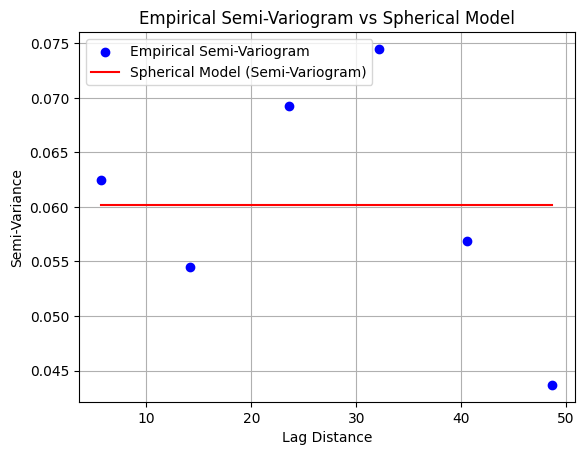

In [398]:
# Define the spherical variogram model (unchanged)
def spherical_variogram(h, sill, range_, nugget):
    h = np.array(h)
    gamma = np.zeros_like(h)
    mask = h <= range_
    gamma[mask] = nugget + sill * (1.5 * (h[mask] / range_) - 0.5 * (h[mask] / range_) ** 3)
    gamma[~mask] = nugget + sill
    return gamma

# Assuming lags, sill, range_, nugget, and ok (Ordinary Kriging) are defined earlier
theoretical_variogram = spherical_variogram(lags, sill, range_, nugget)

# Extract variogram information for plotting
lags = ok.lags  
semivariance = ok.semivariance  

# Convert the variogram to semi-variogram Semi-variogram is half of the variogram
semi_variance = semivariance / 2  

# Plot the empirical semi-variogram and theoretical model
plt.figure()
plt.scatter(lags, semi_variance, color='blue', label='Empirical Semi-Variogram')
plt.plot(lags, theoretical_variogram / 2, color='red', label='Spherical Model (Semi-Variogram)')
plt.xlabel('Lag Distance')
plt.ylabel('Semi-Variance')
plt.title('Empirical Semi-Variogram vs Spherical Model')
plt.grid()
plt.legend()
plt.show()

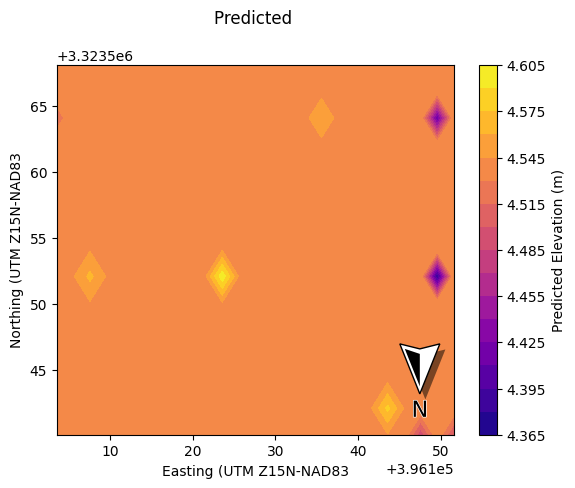

In [399]:
# Step 5: Plot the predicted surface
fig, ax = plt.subplots()
contour = ax.contourf(gridx, gridy, z_pred, levels=20, cmap='plasma')
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":180})
plt.colorbar(contour, label='Predicted Elevation (m)')
plt.title('Predicted ',pad=30)
plt.xlabel('Easting (UTM Z15N-NAD83')
plt.ylabel('Northing (UTM Z15N-NAD83')
plt.show()

Prediction at the North-East and Sound-East qaudrant is better and explain the model best in these part.

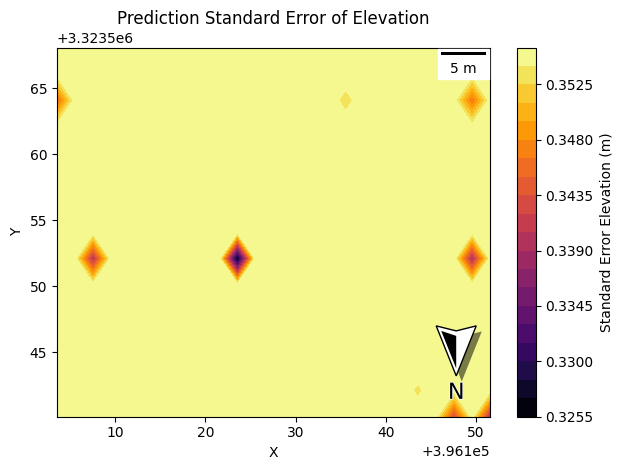

In [401]:
# Step 6: Plot the prediction standard error
fig, ax = plt.subplots()
contour = ax.contourf(gridx, gridy, np.sqrt(ss_pred), levels=20, cmap='inferno')
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":180})
scalebar = ScaleBar(0.001, "km")  
ax.add_artist(scalebar)
plt.colorbar(contour, label='Standard Error Elevation (m)')
plt.title('Prediction Standard Error of Elevation')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

The model does near the data points but exhibits higher error when there is no data (yellow regions) A few data points near the south-west quadrant and also some few North-West quadrant will improve predictions of the model.

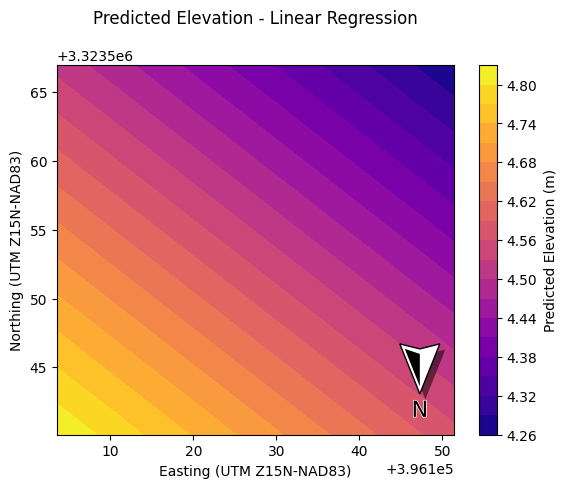

In [403]:
# Convert x and y to NumPy arrays (if they are not already)
x = np.array(lamaras.geometry.x)
y = np.array(lamaras.geometry.y)

# Generate the Linear Regression predicted surface on a grid
x_range = np.linspace(x.min(), x.max(), 50)
y_range = np.linspace(y.min(), y.max(), 50)
x_mesh, y_mesh = np.meshgrid(x_range, y_range)
z_pred_linear = model.intercept_ + model.coef_[0] * x_mesh + model.coef_[1] * y_mesh

# Plot the predicted surface for Linear Regression
fig, ax = plt.subplots()
contour = ax.contourf(x_mesh, y_mesh, z_pred_linear, levels=20, cmap='plasma')
plt.colorbar(contour, label='Predicted Elevation (m)')

# Add labels and title
plt.title('Predicted Elevation - Linear Regression', pad=30)
plt.xlabel('Easting (UTM Z15N-NAD83)')
plt.ylabel('Northing (UTM Z15N-NAD83)')

# Add north arrow (if applicable)
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":180})

plt.show()



Comparing the predicted elevation from Kriging and the linear regression model, it was found that Kriging provides better predictions. This is because Kriging accounts for spatial variability, resulting in a more uniform elevation prediction. Additionally, it allows for the identification of spot holes at the site during data collection, where some points were intentionally taken on the concrete pad at hole locations. In contrast, the linear regression predicted surface fails to accurately identify these